# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
import sys
import math
import copy
sys.path.append('../')
import iads as iads
from iads import LabeledSet as ls
from iads import Classifiers as cl
from iads import util_iads as ui
from iads import utils as ut
from iads import engineering as en
from iads import kmoyennes as km
from iads import cluster as ct
from iads import multiclasses as cm
from iads import multiClassClassifier as mcl

## Chargement des données (base MovieLens + enrichissements)

In [2]:
# Chargement des données MovieLens
#movies = pd.read_csv("data/ml-20m/movies.csv", encoding='utf8')
movies = pd.read_csv("data/ml-20m/moviesFiltree.csv", encoding='utf8', index_col=0)
links = pd.read_csv("data/ml-20m/links.csv", encoding='utf8')
ratings = pd.read_csv("data/ml-20m/ratings.csv", encoding='utf8')
tags = pd.read_csv("data/ml-20m/tags.csv", encoding='utf8')
genomeS = pd.read_csv("data/ml-20m/genome-scores.csv", encoding='utf8')
genomeT = pd.read_csv("data/ml-20m/genome-tags.csv", encoding='utf8')

In [3]:
# Chargement des données complémentaires
acteurs = pkl.load(open("data/act_v2.pkl", "rb"))
equipes = pkl.load(open("data/crew_v2.pkl", "rb"))
films = pkl.load(open("data/film_v2.pkl", "rb"))

<h2>Filtrage des données</h2>

In [4]:
"""
print("BEFORE")
print(len(movies))
#print(len(films))
moviesFilter = []
filmId = []
cpt = 0
for i in range(len(films)):
    filmId.append(films[i]["id"])
    
for i in range(len(movies)):
    line = links.loc[links['movieId'] == movies.iloc[i]["movieId"]]
    value = float(line.iloc[0]["tmdbId"])
    if(math.isnan(value)):
        cpt += 1
        continue
    if(value in filmId):
        moviesFilter.append(movies.iloc[i]["movieId"])
    else:
        cpt += 1
movies = movies[movies.movieId.isin(moviesFilter)]
links = links[links.movieId.isin(moviesFilter)]
ratings = ratings[ratings.movieId.isin(moviesFilter)]
print("\nAFTER")
print(len(movies))
movies.to_csv("data/ml-20m/moviesFiltree.csv", encoding='utf8')
"""

'\nprint("BEFORE")\nprint(len(movies))\n#print(len(films))\nmoviesFilter = []\nfilmId = []\ncpt = 0\nfor i in range(len(films)):\n    filmId.append(films[i]["id"])\n    \nfor i in range(len(movies)):\n    line = links.loc[links[\'movieId\'] == movies.iloc[i]["movieId"]]\n    value = float(line.iloc[0]["tmdbId"])\n    if(math.isnan(value)):\n        cpt += 1\n        continue\n    if(value in filmId):\n        moviesFilter.append(movies.iloc[i]["movieId"])\n    else:\n        cpt += 1\nmovies = movies[movies.movieId.isin(moviesFilter)]\nlinks = links[links.movieId.isin(moviesFilter)]\nratings = ratings[ratings.movieId.isin(moviesFilter)]\nprint("\nAFTER")\nprint(len(movies))\nmovies.to_csv("data/ml-20m/moviesFiltree.csv", encoding=\'utf8\')\n'

<h2>Visionnage des données</h2>

In [5]:
#links
#ratings
#tags
#genomeS
#genomeT
#movies
#films[9]
#acteurs[0]
#equipes[0][194]

## Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [4]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
ue = en.UtilsEngineering(films, acteurs)
print("Tom Hanks à joué dans", ue.actorsPlayedMovies["Tom Hanks"]["Total"], "films")
print("Tom Hanks à joué dans", ue.actorsPlayedMovies["Tom Hanks"]["Comedy"], "comédies")

UtilsEngineering init in process
UtilsEngineering init successful
Tom Hanks à joué dans 57 films
Tom Hanks à joué dans 33 comédies


# Présentation du traitement
<strong><font color="blue">[P]</font></strong> = Protocole<br/>
<strong><font color="green">[Q]</font></strong> = Question<br/>
<strong><font color="green">[A]</font></strong> = Réponse<br/>
<strong><font color="orange">[E]</font></strong> = Exploitation des données<br/>
<strong><font color="purple">[R]</font></strong> = Approfondissement<br/>
<strong><font color="red">[C]</font></strong> = Critique<br/>
## Mise en situation
Notre entreprise de traitement de données nommée <strong>Kerneloud</strong> veut se faire un nom dans le milieu de la data science afin d'attirer les VC's de la sillicon valley à Paris.
Pour cela Kerneloud va viser le secteur du divertissement multimédia pour faire ses preuves.<br/>

<strong><font color="green">[Q]</font></strong> Pourquoi le milieu du divertissement ?<br/>
<strong><font color="green">[A]</font></strong> Le budget ne permet que de se constituer d'une base de donnée..

## Genres predictions
Pour commencer Kerneloud veut publier un article afin de predire si une categorie sera rentable à partir des données des anciens films récoltés<br/>

<strong><font color="blue">[P]</font></strong> Faire un dataframe sur les categories, leur quantites de films et leur engagements puis le tester sur des classifiers afin de prédire la note moyenne des films de la categorie

<strong><font color="green">[Q]</font></strong> A partir de quoi est défini une bonne catégorie ?<br/>
<strong><font color="green">[A]</font></strong> La médianne de la note moyenne d'une catégorie sert de temoin pour définir une bonne catégorie

<strong><font color="green">[Q]</font></strong> Pourquoi la médianne à été choisie ?<br/>
<strong><font color="green">[A]</font></strong> Cela permet d'équilibrer les données vu le peu de catégories pouvant etre utilisé (le budget..)

In [7]:
#ge = en.GenresEngineering(movies,(links, films))
#df = ge.toDataFrame()
#df.to_csv("data/engineering/genres.csv", encoding='utf8')
df = pd.read_csv("data/engineering/genres.csv", encoding='utf8', index_col=0)
df

,quantite,engagement,target
Adventure,0.160587,0.653805,-1
Animation,0.061394,0.234012,1
Children,0.072183,0.259724,-1
Comedy,0.625427,0.784191,-1
Fantasy,0.091354,0.347602,-1
Romance,0.299752,0.376248,-1
Drama,1.000000,1.000000,1
Action,0.253648,0.841496,-1
Crime,0.209329,0.394125,1
Thriller,0.305107,0.692253,-1


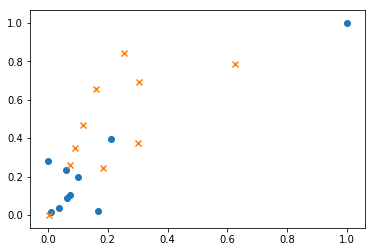

In [8]:
une_base = ls.LabeledSet(2)
for i in range(len(df)):
    une_base.addExample([df.iloc[i]['quantite'], df.iloc[i]['engagement']], df.iloc[i]['target'])
ut.plot2DSet(une_base)

No handles with labels found to put in legend.


Mean accuracy 63.6666666666667
Variance accuracy 181.27777777777777


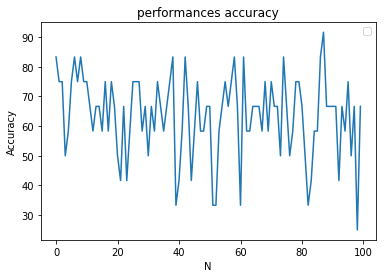

(63.6666666666667, 181.27777777777777)

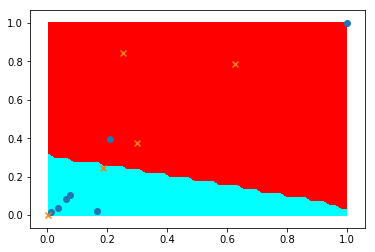

In [9]:
#ut.affiche_base(une_base)
knn = cl.ClassifierKNN(une_base.getInputDimension(), 3)
ut.super_entrainement(100, une_base, knn, 40)

<strong><font color="orange">[E]</font></strong> On obtient un classifier avec une précision un peu près abordable. Cela est en parti du au fait qu'on préfère s'entrainer sur une minorité de données. Vu la disposition des données ici qui sont entrelacées et non démarquées par une frontiere, le Knn semble être un bon choix.
On peut donc prédire quand une catégorie ou une de ses sous categories de film sera rentable grace à sa quantité de films et l'engagement que les utilisateurs lui ont accordé. 

<strong><font color="red">[C]</font></strong> Il y a tres peu de données ici, il faudrait plus de catégories et de sous categories pour que le travail soit efficace. De plus le plus gros du travail s'effectue dans la création du dataframe, cela est donc très couteux en temps. Le problème traité ici pourrait etre résolu avec de la programmation linéaire. Enfin il y a peut être une corrélation entre l'engagement des utilisateurs et la note obtenue, il faudrait donc choisir d'autres arguments pour départager les différentes catégories

<strong><font color="purple">[R]</font></strong> On pourrait rajouter des dimensions afin de mieux départager les catégories et ainsi gagner en précision. On pourrait entrainer d'autres classifiers et prendre celui avec la meilleure précision.

## Movies prediction
Le premier article publié par les docteurs de <strong>kerneloud</strong> à eu un succès régional de par sa simplicité à traiter et vulgariser un problème et cela leur à permis d'avoir des financements de la part des investisseurs de <strong>station E</strong>.<br/>
Des investisseurs et producteurs venus de Cannes voudraient exporter le cinéma français à l'international et pour cela ils voudraient les ingrédients pour avoir un bon film.
    
<strong><font color="blue">[P]</font></strong> Faire un dataFrame sur les films, leur genre, le nombre de votes qu'ils ont reçuent, leur langue originale, la note moyenne des films dans lesquels les acteurs principaux ont joués et leur popularité afin de prédire leur note

In [5]:
me = en.MoviesEngineering(films, (ue.plays, ue.actorsMeanMovies, ue.languages))
df = me.toDataFrame("mean")
df

MoviesEngineering init in process
MoviesEngineering init successful
stack original_language
mean 6.105678608592241


,vote_count,mean_main_actors,popularity,original_language,target
Toy Story,0.453466,0.653343,0.428418,en,1
Jumanji,0.265622,0.652299,0.055441,en,1
Grumpier Old Men,0.006648,0.633164,0.114305,en,1
Waiting to Exhale,0.002612,0.604392,0.054876,en,-1
Father of the Bride Part II,0.013675,0.605705,0.128245,en,-1
Heat,0.142545,0.333967,0.257092,en,1
Sabrina,0.012346,0.688355,0.116205,en,-1
Tom and Huck,0.003466,0.582065,0.067104,en,-1
Sudden Death,0.013248,0.598221,0.110806,en,-1
GoldenEye,0.087987,0.620224,0.312834,en,1


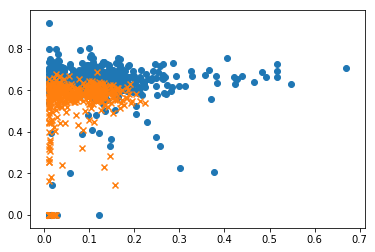

In [11]:
lsNote = ls.LabeledSet(2)
for i in range(1000):
    lsNote.addExample([df.iloc[i]['popularity'], df.iloc[i]['mean_main_actors']], df.iloc[i]['target'])
ut.plot2DSet(lsNote)

No handles with labels found to put in legend.


Mean accuracy 78.94142857142857
Variance accuracy 20.852283673469387


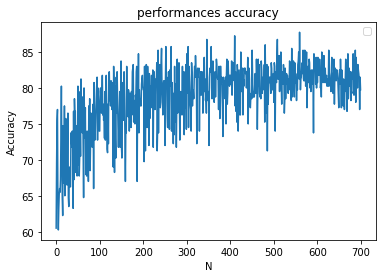

(78.94142857142857, 20.852283673469387)

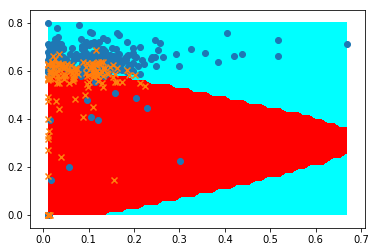

In [12]:
kernel = cl.KernelPoly()
gradient = cl.ClassifierGradientStochastiqueKernel(6, 0.01, kernel)
ut.super_entrainement(700, lsNote, gradient, 60)

No handles with labels found to put in legend.


Mean accuracy 63.84357142857143
Variance accuracy 21.42838724489796


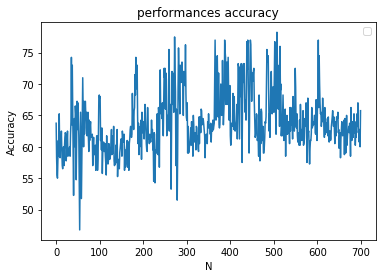

(63.84357142857143, 21.42838724489796)

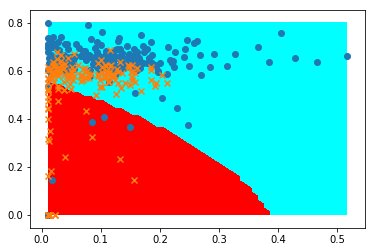

In [13]:
kernel = cl.KernelPoly()
gradient = cl.ClassifierGradientBatchKernel(6, 0.045, kernel)
ut.super_entrainement(700, lsNote, gradient, 60)

In [15]:
dataHeight = 500
"""
Fonction qui initialise un multiClassClassifier
avec un dataFrame et ses labels correspondants
engineering: Engineering, les données traites
classifier: Classifier, initialisé sans entrainement
label: String, colonne du dataframe pour définir les differentes classes
n: int, nombre d'entrainement que chaque classifier fera
"""
def initMultiClassClassifier(engineering, classifier, label, n):
    temoins = set(engineering.df[label])
    mcClassifier = mcl.MultiClassClassifier()
    for l in temoins:
        df = engineering.toDataFrame("vs", label, l)
        labSet = ls.LabeledSet(len(list(df))-1)
        for i in range(len(df[:dataHeight])):
            inter = []
            for k in list(df.drop(columns="target")):
                inter.append(df.iloc[i][k])
            labSet.addExample(inter, df.iloc[i]["target"])
        c = copy.deepcopy(classifier)
        ut.entrainement(n, labSet, c)
        mcClassifier.add(l, c)
    return mcClassifier

In [16]:
perceptron = cl.ClassifierPerceptronKernel(6, 0.05, cl.KernelPoly())
clMulti = initMultiClassClassifier(me, perceptron, "original_language", 100)

multiClassClassifier init
vs 
Mean accuracy 99.985
Variance accuracy 0.022274999999999986
vs sq
Mean accuracy 100.0
Variance accuracy 0.0
vs is
Mean accuracy 99.99
Variance accuracy 0.009899999999999999
vs ar
Mean accuracy 99.515
Variance accuracy 5.242274999999999
vs la
Mean accuracy 99.99
Variance accuracy 0.009899999999999999
vs ms
Mean accuracy 100.0
Variance accuracy 0.0
vs tr
Mean accuracy 100.0
Variance accuracy 0.0
vs jv
Mean accuracy 100.0
Variance accuracy 0.0
vs lv
Mean accuracy 99.99
Variance accuracy 0.009899999999999999
vs ne
Mean accuracy 100.0
Variance accuracy 0.0
vs bs
Mean accuracy 100.0
Variance accuracy 0.0
vs bm
Mean accuracy 100.0
Variance accuracy 0.0
vs ta
Mean accuracy 100.0
Variance accuracy 0.0
vs gl
Mean accuracy 100.0
Variance accuracy 0.0
vs el
Mean accuracy 99.99
Variance accuracy 0.004899999999999999
vs fr
Mean accuracy 92.755
Variance accuracy 232.13747499999997
vs es
Mean accuracy 99.115
Variance accuracy 1.5442750000000003
vs fy
Mean accuracy 99.99
V

In [19]:
df = me.toDataFrame(cluster=True)
labelTest = ls.LabeledSet(len(list(df))-1)
for i in range(len(df[:dataHeight])):
    inter = []
    for k in list(df.drop(columns=["original_language"])):
        inter.append(df.iloc[i][k])
    labelTest.addExample(inter, df.iloc[i]["original_language"])
    
unique_elements, counts_elements = np.unique([me.df["original_language"][:dataHeight]], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

stack original_language
Frequency of unique values of the said array:
[['ar' 'cn' 'de' 'en' 'es' 'fa' 'fr' 'hr' 'it' 'ja' 'nl' 'pt' 'ru' 'zh']
 ['1' '2' '2' '458' '3' '1' '17' '1' '5' '1' '1' '1' '1' '6']]


In [14]:
i = 28
print(clMulti.predict(labelTest.getX(i)))
labelTest.getY(i)

en


array(['fr'], dtype='<U2')

## Genres Cluster
La dernière collaboration des chercheurs de <strong>Kerneloud</strong> leur à permis de se faire connaître à l'interational et de recevoir des financements d'investisseurs d'un peu partout dans le monde. Tous ce travail à permis d'attirer une entreprise de Neverllywood, <strong>Werner Bros</strong>. La compagnie <strong>WB</strong> peine à produire ses résultats trimestrielles et pour cela elle voudrait se relancer en produisant un film qui touche la plus large gamme de public possible.

<strong><font color="blue">[P]</font></strong> Faire un dataFrame sur les genres et les films qui y sont pour déterminer les genres similaires grâce aux centroides du cluster

In [ ]:
gce = en.GenresClusterEngineering(films)
df = gce.toDataFrame(cluster=True)
df

In [ ]:
"""
Fonction qui permet de visualiser les distances
entre 2 dimension d'un dataFrame
df: DataFrame, dataFrame à visionner
x: String, nom d'une colonne du dataFrame
y: String, nom d'une colonne du dataFrame
"""
def compareCentroide(df, x, y):
    dfBis = df[[x, y]][:1000]
    dfBis = dfBis.rename({x:"X", y:"Y"}, axis='columns')
    centroide, matrice = km.kmoyennes(3, dfBis, 0.005, 1000)
    km.affiche_resultat(dfBis,centroide,matrice)
    return centroide, matrice

In [ ]:
centroide2d, matrice2d = compareCentroide(df, "Action", "Adventure")
centroide, matrice = km.kmoyennes(20, df[:500], 0.05, 1000)

In [ ]:
centroide2d = centroide2d.dropna()
centroide = centroide.dropna()

In [ ]:
print(centroide2d)
#print(matrice2d)
print("\n_____________________________________________FROM__2D__TO__20D___________________________________________________\n")
print(centroide)
#print(matrice)

In [ ]:
M_Fusion = ct.clustering_hierarchique(centroide, "manhattan")
print('\nLa matrice M_Fusion obtenue :\n',M_Fusion)

In [ ]:
ct.dendogramme(M_Fusion)

In [ ]:
"""
Fonction retournant le ou les categories correspondant
à chaque centroide
centroide: dataframe, contient les categories et leur distance par rapport au centroide
"""
def affinite(centroide):
    final = {}
    for i in range(len(centroide)):
        inter = []
        for k in list(centroide):
            if centroide.iloc[i][k] >= 1.0:
                inter.append(k)
        final[i] = inter
    return final

In [ ]:
affinite(centroide)

<strong><font color="orange">[E]</font></strong> Les clusters obtenus nous permettent d'observer les catégories qui ont la même affinité. Pondérer cela avec les distances obtenues lors du clustering hierarchique nous permet de trouver une ou deux catégories capables d'être en commun avec d'autres catégories ne dépassant pas un certain seuil d'incompatibilité.

<strong><font color="purple">[R]</font></strong> On pourrait filtrer les films de départ afin de ne conserver que ceux suceptible de nous intéresser. Par exemple pour produire un film de nos jours dont la catégorie est suceptible de toucher le plus de publique entre 30 et 40 ans dans le marché Est asiatique, il serait plus judicieux de ne conserver que les films qui ont eu un succèes dans cette région et datant d'après l'année 2000

<strong><font color="green">[Q]</font></strong> Pourquoi ne pas avoir automatisé l'approfondissement ?<br/>
<strong><font color="green">[A]</font></strong> Le budget..